In [1]:
import os
os.chdir('/Users/saikatmitra/OvGU Lectures/SEM III/AI Lab Project/Final/project/validating_attribution_techniques')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets.widgets import Label, FloatProgress, FloatSlider, Button, RadioButtons, Checkbox, Dropdown, HTML, Image, ToggleButtons
from ipywidgets.widgets import Layout, HBox, VBox
from IPython.display import display
from ipywidgets import Output
import time
import threading
from PIL import Image as PILImage
import io
import cv2
from matplotlib.pyplot import imshow
import torch
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.transforms import IdentityTransform
from tqdm import tqdm
from time import sleep

In [3]:
# !pip install shapely

In [4]:
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images
from commons.api.viz import visualize_saliency_overlay
from commons.api.method.attribution import attribution

from commons.api.target_layer import get_model_and_target_layer
from commons.api.pil_to_tensor import pil_to_tensor
from commons.api.method.occlusion import apply_patch, generate_img_occlusion_list, get_nonintersecting_patch_coord_mask, generate_multipatch_occlusion_list_reduce_saliency
from commons.api.method.adv_perturb import adversarial_noise

from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics
from commons.api.segment_saliency import yolo_generate_segmentation_mask

In [5]:
# Variables to store the selected values
selected_model = None
selected_attribution = None
selected_perturbation = None
selected_occlusion = None
selected_patch_size = None
selected_adversarial_noise_level = None

In [6]:
model_choice = widgets.RadioButtons(
    options=['ResNet18', 'ResNet50', 'VGG16', 'InceptionV3'],
    value=None,
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Choose the model:',
    disabled=False
)

In [7]:
attribution_choice = widgets.RadioButtons(
    options=['GradCAM', 'ScoreCAM', 'SmoothGradCAM++', 'LayerCAM'],
    value=None,
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Choose the attribution technique',
    disabled=False
)

In [8]:
# Create the first radio button for choosing the perturbation technique
perturbation_choice = widgets.RadioButtons(
    options=['Occlusion patch', 'Adversarial Noise'],
    value=None,
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Choose the perturbation technique',
    disabled=False
)

In [9]:
# Create a container for the second set of radio buttons
occlusion_choice = widgets.RadioButtons(
    options=['Single patch'],
    value = None,
    description='Choose an occlusion type:',
    disabled=False
)
occlusion_choice.layout.visibility = 'hidden'

In [10]:
patch_size = widgets.IntSlider(
    value=0.0,
    min=0,
    max=100,
    step=1,
    description='Set patch size :',
    disabled=False,
)
patch_size.layout.visibility = 'hidden'

In [11]:
# Create a slider for adversarial noise (hidden by default)
adversarial_noise_slider = widgets.FloatSlider(
    value=0.0,
    min=0,
    max=1,
    step=0.01,
    description='Adversarial Noise Level:',
    disabled=False,
)
adversarial_noise_slider.layout.visibility = 'hidden'

In [12]:
# Define a function to update the visibility of the occlusion choices and patch size dropdown
def update_visibility(change):
    if perturbation_choice.value == 'Occlusion patch':
        occlusion_choice.layout.visibility = 'visible'
        patch_size.layout.visibility = 'visible'
    else:
        occlusion_choice.layout.visibility = 'hidden'
        patch_size.layout.visibility = 'hidden'

def update_patch_size_visibility(change):
    if change.new == 'Single patch' or change.new == 'Multi patch':
        patch_size.layout.visibility = 'visible'
    else:
        patch_size.layout.visibility = 'hidden'

def update_noise_visibility(change):
    if perturbation_choice.value == 'Adversarial Noise':
        adversarial_noise_slider.layout.visibility = 'visible'
    else:
        adversarial_noise_slider.layout.visibility = 'hidden'


perturbation_choice.observe(update_visibility, names='value')
perturbation_choice.observe(update_noise_visibility, names='value')
occlusion_choice.observe(update_patch_size_visibility, names='value')

In [13]:
# Define a function to update the selected values
def update_selected_values(change):
    global selected_perturbation, selected_occlusion, selected_patch_size, selected_model, selected_attribution, selected_adversarial_noise_level
    if model_choice.value:
        selected_model = model_choice.value
    if attribution_choice.value:
        selected_attribution = attribution_choice.value
    if perturbation_choice.value:
        selected_perturbation = perturbation_choice.value
    if occlusion_choice.value:
        selected_occlusion = occlusion_choice.value
    if patch_size.value:
        selected_patch_size = patch_size.value
    if adversarial_noise_slider.value:
        selected_adversarial_noise_level = adversarial_noise_slider.value

In [14]:
model_choice.observe(update_selected_values, names='value')
attribution_choice.observe(update_selected_values, names='value')
perturbation_choice.observe(update_selected_values, names='value')
occlusion_choice.observe(update_selected_values, names='value')
patch_size.observe(update_selected_values, names='value')
adversarial_noise_slider.observe(update_selected_values, names='value')

In [15]:
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False  # True to accept multiple files upload else False
)

In [16]:
display(uploader)

FileUpload(value=(), accept='image/*', description='Upload')

In [17]:
uploaded_image = uploader.value

if uploaded_image:
    # Access the first element of the tuple (index 0) to get the uploaded image data
    uploaded_image_data = uploaded_image[0]
    # Create an Image widget to display the uploaded image
    uploaded_image_widget = Image(value=uploaded_image_data['content'], format='png')  # Set the format as needed
    # # Display the uploaded image
    # display(uploaded_image_widget)

In [18]:
# Convert image into numpy array
def convert_widget_image_to_numpy(image_widget, target_size=(224, 224)):
    # Get the image data as bytes from the widget
    image_bytes = image_widget.value
    # Open the image with PIL
    image = PILImage.open(io.BytesIO(image_bytes))
    # Resize the image to the target size (e.g., 224x224)
    image = image.resize(target_size)
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)

    return image_array

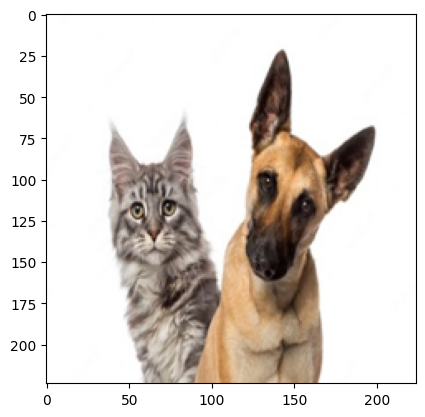

In [19]:
image = convert_widget_image_to_numpy(uploaded_image_widget)
type(image)
image.shape
imshow(PILImage.fromarray(image))

In [20]:
# Display the widgets in a VBox layout
ui = widgets.VBox([
    # file_upload,
    model_choice,
    attribution_choice,
    perturbation_choice,
    occlusion_choice,
    patch_size,
    adversarial_noise_slider,
    # process_button,
    # output
])

# Display the UI
display(ui)

In [21]:
img_idx = 0

def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

def saliency_occluded_image(image, selected_model, selected_attribution):
    use_cuda = False
    device = torch.device("cuda" if use_cuda else "cpu")
    original_image = PILImage.fromarray(image)
    input_tensor = pil_to_tensor(original_image).to(device)
    model, target_layer = get_model_and_target_layer(selected_model)
    model = model.to(device).eval()
    mask = yolo_generate_segmentation_mask(image)
    # print(mask)
    cam, cam_idx, probs = attribution(model, input_tensor, selected_attribution, target_layer)
    
    classes = get_imagenet_classes()
    sample_occlu_imgs = generate_img_occlusion_list_no_saliency(image, selected_patch_size)
    rows = len(sample_occlu_imgs)
    titles = ["Reference", "Patched"]
    fig, axes = plt.subplots(ncols=3, nrows=rows)
    # Iterate through axes and turn off the axes for each subplot
    for row in axes:
        for ax in row:
            ax.axis('off')
            
    for row in range(axes.shape[0]):
        # for col in [0, 2, 4, 6]:
        for col in [0, 1]:
            # Add the title at the bottom of the image
            title = titles[col]
            axes[row, col].text(0.5, -0.09, title, horizontalalignment='center', fontsize=12, fontweight='bold', transform=axes[row, col].transAxes)
    
    fig.set_figheight(45)
    fig.set_figwidth(15)
    for row in tqdm(range(axes.shape[0])):
        idx = row
        img = PILImage.fromarray((sample_occlu_imgs[row] * 255).astype(np.uint8))
        occlu_input_tensor = pil_to_tensor(img).to(device)
    
        pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model, occlu_input_tensor, selected_attribution, target_layer)

        visualize_saliency_overlay(axes[row, 0], original_image, cam, probs, cam_idx, classes);
        visualize_saliency_overlay(axes[row, 1], img, pertubed_grad_cam, pertubed_grad_probs, pertubed_grad_idx, classes);    
  
        
        sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(cam, pertubed_grad_cam, mask) 
        text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}" + (f"\nIOR: {ior_grad:.2f}" if ior_grad is not None else "")
            
        axes[row, 2].imshow(text_to_rgba(text_grad, color="blue", fontsize=7, dpi=200))

img_idx = 0

def saliency_noisy_image(image, selected_model, selected_attribution):
    ep = selected_adversarial_noise_level
    use_cuda = False
    device = torch.device("cuda" if use_cuda else "cpu")
    original_image = PILImage.fromarray(image)
    input_tensor = pil_to_tensor(original_image).to(device)
    model, target_layer = get_model_and_target_layer(selected_model)
    model = model.to(device).eval()
    mask = yolo_generate_segmentation_mask(image)
    cam, cam_idx, probs = attribution(model, input_tensor, selected_attribution, target_layer)
    
    classes = get_imagenet_classes()

    in_ten = torch.tensor(image).permute((2, 0, 1)).unsqueeze(0) / 255.0
    in_ten = in_ten.to(device)
    
    # titles = [ "GradCAM", "ScoreCAM", "SmoothGradCAMpp", "LayerCAM"]
    titles = ["Reference", "Noise in salient areas", "Noise in non-salient areas"]
    fig, axes = plt.subplots(ncols=6, nrows=1)
    # Iterate through axes and turn off the axes for each subplot
    for ax in axes:
        ax.axis('off')
    for i, ax in enumerate(axes):
        if i % 2 == 0:
            title_index = i // 2
            ax.text(0.5, -0.1, titles[title_index], horizontalalignment='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    
    
    fig.set_figheight(25)
    fig.set_figwidth(20)

    grad = torch.from_numpy(np.array(PILImage.fromarray(cam).resize(mask.shape))).to(device)
    out_ten_grad = adversarial_noise(in_ten, model, int(cam_idx), lower_bound=0, upper_bound=1, epsilon=ep, mask = grad)
    pertubed_grad_cam, pertubed_grad_idx, pertubed_grad_probs = attribution(model,  out_ten_grad.squeeze(), "GradCAM", target_layer)
    anti_out_ten_grad = adversarial_noise(in_ten, model, int(cam_idx), lower_bound=0, upper_bound=1, epsilon=ep, anti_adv=True, mask = grad)
    anti_pertubed_grad_cam, anti_pertubed_grad_idx, anti_pertubed_grad_probs = attribution(model,  anti_out_ten_grad.squeeze(), "GradCAM", target_layer)
    visualize_saliency_overlay(axes[0], original_image, cam, probs, cam_idx, classes);
    visualize_saliency_overlay(axes[2], out_ten_grad[0].permute((1, 2, 0)).cpu().numpy(), pertubed_grad_cam, pertubed_grad_probs, cam_idx, classes);    
    visualize_saliency_overlay(axes[4], anti_out_ten_grad[0].permute((1, 2, 0)).cpu().numpy(), anti_pertubed_grad_cam, anti_pertubed_grad_probs, cam_idx, classes);    
    sim_grad, cc_grad, nss_grad, auc_grad, emd_grad, ior_grad = calculate_metrics(cam, pertubed_grad_cam, mask) 
    text_grad = f"Sim: {sim_grad:.2f}\nCC: {cc_grad:.2f}\nNSS: {nss_grad:.2f}\nAUC: {auc_grad:.2f}\nEMD: {emd_grad:.2f}"+ (f"\nIOR: {ior_grad:.2f}" if ior_grad is not None else "")
    anti_sim_grad, anti_cc_grad, anti_nss_grad, anti_auc_grad, anti_emd_grad, anti_ior_grad = calculate_metrics(cam, anti_pertubed_grad_cam, mask) 
    anti_text_grad = f"Sim: {anti_sim_grad:.2f}\nCC: {anti_cc_grad:.2f}\nNSS: {anti_nss_grad:.2f}\nAUC: {anti_auc_grad:.2f}\nEMD: {anti_emd_grad:.2f}"+ (f"\nIOR: {ior_grad:.2f}" if ior_grad is not None else "")
    axes[1].imshow(text_to_rgba(text_grad, color="blue", fontsize=10, dpi=200))
    axes[3].imshow(text_to_rgba(anti_text_grad, color="blue", fontsize=10, dpi=200))
    

In [22]:
process_button = widgets.Button(description="Process Image")
output = widgets.Output()

display(process_button, output)

def process_image(b):
    # global image, selected_model, selected_attribution, selected_perturbation, selected_occlusion, selected_patch_size, selected_adversarial_noise_level
    
    # Create a new figure and display the heatmap
    with output:
        if selected_perturbation == 'Occlusion patch':
            saliency_occluded_image(image, selected_model, selected_attribution)
            plt.show()
        if selected_perturbation == 'Adversarial Noise':
            saliency_noisy_image(image, selected_model, selected_attribution)
            plt.show()
    
process_button.on_click(process_image)

Button(description='Process Image', style=ButtonStyle())

Output()